# BigQuery and London weather data

[BigQuery](https://cloud.google.com/bigquery/docs/) is a petabyte-scale analytics data warehouse that you can use to run SQL queries over vast amounts of data in near realtime. This page shows you how to get started with the Google BigQuery API using the Python client library.

## Import the libraries used in this tutorial

In [1]:
from google.cloud import bigquery
import pandas as pd
pd.set_option('display.max_columns', 500)

## Initialize a client

To use the BigQuery Python client library, start by initializing a client. The BigQuery client is used to send and receive messages from the BigQuery API.

### Client project
The `bigquery.Client` object uses your default project. Alternatively, you can specify a project in the `Client` constructor. For more information about how the default project is determined, see the [google-auth documentation](https://google-auth.readthedocs.io/en/latest/reference/google.auth.html).


### Client location
Locations are required for certain BigQuery operations such as creating a dataset. If a location is provided to the client when it is initialized, it will be the default location for jobs, datasets, and tables.

Run the following to create a client with your default project:

In [2]:
client = bigquery.Client(location="EU")
print("Client creating using default project: {}".format(client.project))

Client creating using default project: pacific-destiny-243512


To explicitly specify a project when constructing the client, set the `project` parameter:

In [3]:
# client = bigquery.Client(location="US", project="your-project-id")

## Run a query on a public dataset

Use the [Client.query](https://googleapis.github.io/google-cloud-python/latest/bigquery/generated/google.cloud.bigquery.client.Client.html#google.cloud.bigquery.client.Client.query) method to run the query, and the [QueryJob.to_dataframe](https://googleapis.github.io/google-cloud-python/latest/bigquery/generated/google.cloud.bigquery.job.QueryJob.html#google.cloud.bigquery.job.QueryJob.to_dataframe) method to return the results as a pandas [`DataFrame`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html).

<hr>

## Data: Daily weather data from NOAA’s Global Historical Climatology Network (GHCN) 
Link to dataset: https://console.cloud.google.com/marketplace/details/noaa-public/ghcn-d

### Goals:
- Query precipitation data for London on BigQuery using the `google.cloud` library
- Plot precipitation data on a lineplot for 2015

## Steps:
1. Determine which specific weather station to filter data on (city: London, UK)
2. Retrieve precipitation data for London, UK for the year 2015
3. Plot precipitation data

### 1. Determine which specific weather station to filter data on (city: London, UK)

1-1. Find lat/lon of London, UK  
1-2. Using lat/lon range of London, find nearby weather stations

In [58]:
#Choose city/address to retrieve lat/lon coordinates
my_address = "London, UK"

In [59]:
# Get latitude/longitude for London, UK

#!pip3 install geopy
import geopy
from  geopy.geocoders import Nominatim

geolocator = Nominatim(user_agent="my-application")

loc = geolocator.geocode(my_address)

print("latitude is :-" ,loc.latitude,
      "\nlongtitude is:-" ,loc.longitude)

latitude is :- 51.5073219 
longtitude is:- -0.1276474


In [60]:
# Using a range of lat/lon coordinates, find weather stations in or near London, UK

query = """
SELECT
  id,
  name,
  state,
  latitude,
  longitude
FROM
  `bigquery-public-data.ghcn_d.ghcnd_stations`
WHERE
  latitude > {}
  AND latitude < {}
  AND longitude > {}
  AND longitude < {}
""".format(loc.latitude - 0.5, loc.latitude + 0.5,
           loc.longitude - 0.5, loc.longitude + 0.5)

query_job = client.query(
    query,
    # Location must match that of the dataset(s) referenced in the query.
    location="US",
)  # API request - starts the query

london_stations = query_job.to_dataframe()
london_stations

,id,name,state,latitude,longitude
0,UKE00105900,ROTHAMSTED,,51.8067,0.3581
1,UKE00105915,HAMPSTEAD,,51.5608,0.1789
2,UKM00003772,HEATHROW,,51.4780,-0.4610


### 2. Retrieve precipitation data for London, UK for a specific year (e.g., 2015)

In [61]:
# Retrieve data for the Heathrow station

stationid = 'UKM00003772' #HEATHROW

query = """
SELECT
  wx.date,
  wx.value/10.0 AS prcp
FROM
  `bigquery-public-data.ghcn_d.ghcnd_2015` AS wx
WHERE
  id = '{}'
  AND qflag IS NULL
  AND element = 'PRCP'
ORDER BY
  wx.date
""".format(stationid)

query_job = client.query(
    query,
    # Location must match that of the dataset(s) referenced in the query.
    location="US",
)  # API request - starts the query


df = query_job.to_dataframe()
df.head()

,date,prcp
0,2015-01-01,0.3
1,2015-01-02,1.0
2,2015-01-03,3.8
3,2015-01-04,7.1
4,2015-01-05,0.0


#### Filter London precipitation data for 2015 only

In [62]:
# Check 

query = """
SELECT
  *
FROM
  `bigquery-public-data.ghcn_d.ghcnd_2015` AS wx
WHERE
  date >= "2015-01-01"
  AND date <= "2015-12-31"
  AND id = '{}'
  AND qflag IS NULL
  AND element = 'PRCP'
ORDER BY
  wx.date
""".format(stationid)

query_job = client.query(
    query,
    # Location must match that of the dataset(s) referenced in the query.
    location="US",
)  # API request - starts the query

df = query_job.to_dataframe()
df.head()

,id,date,element,value,mflag,qflag,sflag,time
0,UKM00003772,2015-01-01,PRCP,3.0,None,None,S,None
1,UKM00003772,2015-01-02,PRCP,10.0,None,None,S,None
2,UKM00003772,2015-01-03,PRCP,38.0,None,None,S,None
3,UKM00003772,2015-01-04,PRCP,71.0,None,None,S,None
4,UKM00003772,2015-01-05,PRCP,0.0,None,None,S,None


### 3. Plot precipitation data: London, UK in 2015

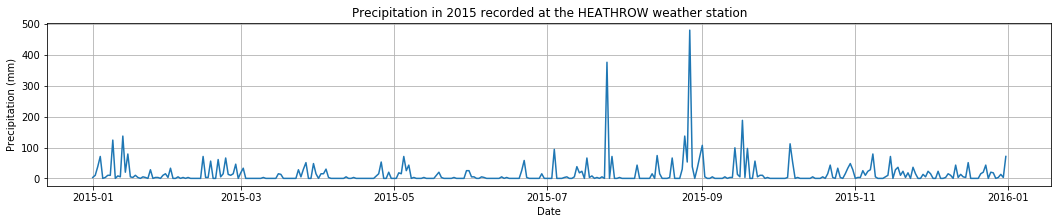

In [82]:
plt.rcParams["figure.figsize"] = [18,3] #change figsize

fig, ax = plt.subplots()
ax.plot(df.date.values, df.value.values)

ax.set(xlabel='Date', ylabel='Precipitation (mm)',
       title='Precipitation in 2015 recorded at the HEATHROW weather station')
ax.grid()


plt.show()

<hr>

## Clustering weather stations in the UK based on their monthly total precipitation

### Goals:
- find monthly precipitation data for every UK weather station
- cluster weather stations based on their monthly total precipitation values using SQL
- plot results on a map

### Where are all the weather stations in the UK?

In [104]:
# Find all UK weather stations

query = """
SELECT
  id,
  name,
  state,
  latitude,
  longitude
FROM
  `bigquery-public-data.ghcn_d.ghcnd_stations`
WHERE
  id LIKE 'UK%'
"""

query_job = client.query(
    query,
    # Location must match that of the dataset(s) referenced in the query.
    location="US",
)  # API request - starts the query

uk_stations = query_job.to_dataframe()
uk_stations

,id,name,state,latitude,longitude
0,UK000044841,HULL,,53.7700,-0.3700
1,UKE00100808,HULL,,53.7667,0.3667
2,UKE00108855,TERRINGTON ST CLEMENT,,52.7450,0.2900
3,UKE00105865,INVERNESS,,57.4867,-4.2231
4,UKE00105926,HAYLING ISLAND,,50.7839,0.9839
5,UKE00105636,KINLOSS,,57.6500,-3.5700
6,UKE00105863,HAWARDEN BRIDGE,,53.2167,-3.0281
7,UKE00105929,RHUM: KINLOCH,,57.0139,-6.2867
8,UKE00105895,SKEGNESS,,53.1467,0.3489
9,UKE00156844,CAWOOD,,53.8275,-1.1467


#### Calculate total precipitation data by month for all UK stations in 2015

In [105]:
# Retrieve prcp data for all UK stations


query = """
SELECT
  id,
  EXTRACT(MONTH FROM date) as month,
  sum(value) as prcp
FROM
  `bigquery-public-data.ghcn_d.ghcnd_2015` AS wx
WHERE
  id LIKE 'UK%'
  AND date >= '2015-01-01'
  AND date <= '2015-12-31'
  AND element = 'PRCP'
GROUP BY
  id, month
ORDER BY
  id, month
LIMIT
  10
""" ## LIMIT 10 for sampling

query_job = client.query(
    query,
    # Location must match that of the dataset(s) referenced in the query.
    location="US",
)  # API request - starts the query


df = query_job.to_dataframe()
df.head()

,id,month,prcp
0,UK000003005,1,2807.0
1,UK000003005,2,1213.0
2,UK000003005,3,1160.0
3,UK000003005,4,569.0
4,UK000003005,5,1166.0


#### Next tasks:
1. Transpose data (unique id per row, months in columns, prcp as cell values)
2. Cluster similar weather stations in the UK using SQL